# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
# помним про PEP-8
# импорты из стандартной библиотеки
import warnings

# импорты сторонних библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# импорты модулей текущего проекта
# длина строки до 78 символов
!pip install scikit-learn==1.1.3
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (
    GridSearchCV, 
    RandomizedSearchCV,
    train_test_split,
    cross_val_score
)

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)

# настройки
warnings.filterwarnings("ignore")

# константы заглавными буквами
RANDOM_STATE = 42

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Загрузка данных и общая информация

In [2]:
data = pd.read_csv('/content/autos (1).csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
data.columns = data.columns.str.lower()
data.rename(columns = {'vehicletype':'vehicle_type', 'registrationyear': 'registration_year',
                     'registrationmonth':'registration_month', 'fueltype':'fuel_type',
                     'numberofpictures':'number_of_pictures'}, inplace = True)
data.columns

Index(['datecrawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'datecreated', 'number_of_pictures', 'postalcode',
       'lastseen'],
      dtype='object')

Удалим неинформативные колонки из датасета. Данные о самом объявления и количесвто фотографий вряд ли могут повлиять на ценообразование.

### Обработка пропущенных значений

In [6]:
data.isna().sum()

datecrawled               0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
datecreated               0
number_of_pictures        0
postalcode                0
lastseen                  0
dtype: int64

Произведем замену пропущенных значений на "заглушку" - ***unknown*** т.к. причина пропусков неявная и есть риск испортить данные.

In [7]:
data[['vehicle_type', 'gearbox', 'model', 'fuel_type', 'repaired']] = \
data[['vehicle_type', 'gearbox', 'model', 'fuel_type', 'repaired']].fillna('unknown')

### Проверка на дубликаты

In [8]:
data.duplicated().sum()

4

In [9]:
data = data.drop_duplicates()
data.shape

(354365, 16)

In [10]:
data['vehicle_type'].unique()

array(['unknown', 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [11]:
data['model'].unique()

array(['golf', 'unknown', 'grand', 'fabia', '3er', '2_reihe', 'other',
       'c_max', '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo',
       'a_klasse', 'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic',
       'transporter', 'punto', 'e_klasse', 'clio', 'kadett', 'kangoo',
       'corsa', 'one', 'fortwo', '1er', 'b_klasse', 'signum', 'astra',
       'a8', 'jetta', 'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter',
       '156', 'escort', 'forester', 'xc_reihe', 'scenic', 'a4', 'a1',
       'insignia', 'combo', 'focus', 'tt', 'a6', 'jazz', 'omega', 'slk',
       '7er', '80', '147', '100', 'z_reihe', 'sportage', 'sorento', 'v40',
       'ibiza', 'mustang', 'eos', 'touran', 'getz', 'a3', 'almera',
       'megane', 'lupo', 'r19', 'zafira', 'caddy', 'mondeo', 'cordoba',
       'colt', 'impreza', 'vectra', 'berlingo', 'tiguan', 'i_reihe',
       'espace', 'sharan', '6_reihe', 'panda', 'up', 'seicento', 'ceed',
       '5_reihe', 'yeti', 'octavia', 'mii', 'rx_reihe', '6er', 'modus',

In [12]:
data['gearbox'].unique()

array(['manual', 'auto', 'unknown'], dtype=object)

In [13]:
data['fuel_type'].unique()

array(['petrol', 'gasoline', 'unknown', 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [14]:
data['brand'].unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'porsche', 'rover', 'land_rover', 'lada'], dtype=object)

### Обработка выбросов и аномальных значений

Пройдемся по всем колличественным признакам и избаимся от аномальных значений и выбросов, если потребуется.

In [15]:
data['registration_year'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1982, 1976, 1983, 1973, 1111, 1969, 1971, 1987, 1986,
       1988, 1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968,
       1977, 1961, 1960, 1966, 1975, 1963, 1964, 5000, 1954, 1958, 1967,
       1959, 9999, 1956, 3200, 1000, 1941, 8888, 1500, 2200, 4100, 1962,
       1929, 1957, 1940, 3000, 2066, 1949, 2019, 1937, 1951, 1800, 1953,
       1234, 8000, 5300, 9000, 2900, 6000, 5900, 5911, 1933, 1400, 1950,
       4000, 1948, 1952, 1200, 8500, 1932, 1255, 3700, 3800, 4800, 1942,
       7000, 1935, 1936, 6500, 1923, 2290, 2500, 1930, 1001, 9450, 1944,
       1943, 1934, 1938, 1688, 2800, 1253, 1928, 1919, 5555, 5600, 1600,
       2222, 1039, 9996, 1300, 8455, 1931, 1915, 4500, 1920, 1602, 7800,
       9229, 1947, 1927, 7100, 8200, 1946, 7500, 35

In [16]:
data['registration_year'].describe()

count    354365.000000
mean       2004.234481
std          90.228466
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64

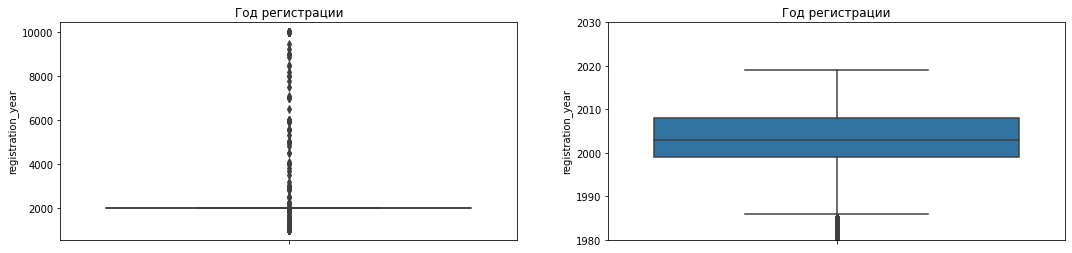

In [17]:
fig, axis = plt.subplots(1,2 , figsize=(18,4))
sns.boxplot(y='registration_year', data=data, ax=axis[0]).set(title='Год регистрации');
sns.boxplot(y='registration_year', data=data, ax=axis[1]).set(title='Год регистрации');
plt.ylim([1980,2030]);

Избавимся от аномалий и опрделим актуальный перод выпуска автомобилей: *с 1990 по 2023 г.г.*

In [18]:
data = data.query('1990 < registration_year < 2023')
data.shape

(341785, 16)

In [19]:
data['datecrawled'].sort_values()

329497    2016-03-05 14:06:22
220583    2016-03-05 14:06:23
324763    2016-03-05 14:06:24
176823    2016-03-05 14:06:24
99885     2016-03-05 14:06:24
                 ...         
304465    2016-04-07 14:36:46
53739     2016-04-07 14:36:54
301030    2016-04-07 14:36:55
339649    2016-04-07 14:36:56
90713     2016-04-07 14:36:58
Name: datecrawled, Length: 341785, dtype: object

***Вывод:*** имеем данные скаченных анкет за 2016 год, поэтому верхнюю границу года регистрации имеет смысл сдвинуть на этот же год.

In [20]:
data = data.query('1990 < registration_year < 2016')
data.shape

(317761, 16)

Проверим остальные количественные характеристики.

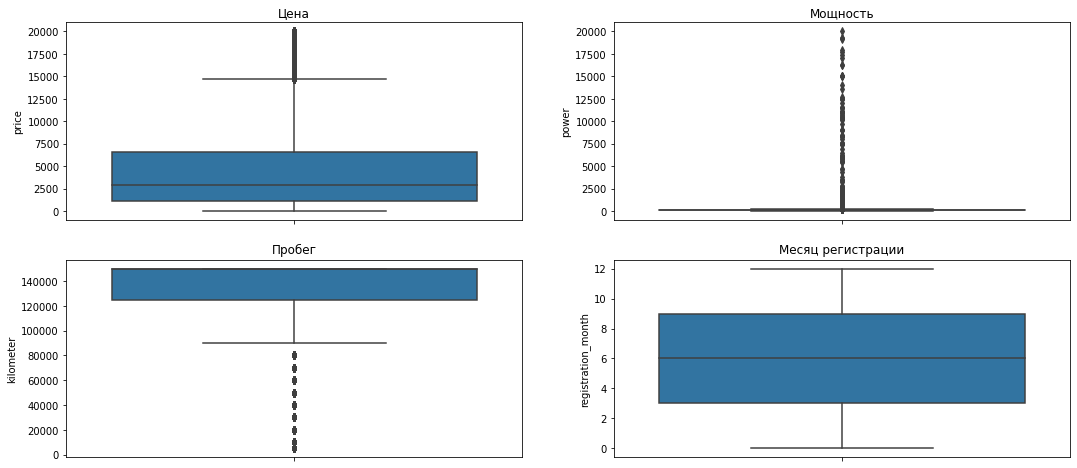

In [21]:
fig, axis = plt.subplots(2,2 , figsize=(18,8))

sns.boxplot(y='price', data=data, ax=axis[0,0]).set(title='Цена');
sns.boxplot(y='power', data=data, ax=axis[0,1]).set(title='Мощность');
sns.boxplot(y='kilometer', data=data, ax=axis[1,0]).set(title='Пробег');
sns.boxplot(y='registration_month', data=data, ax=axis[1,1]).set(title='Месяц регистрации');

In [22]:
data['price'].describe()

count    317761.000000
mean       4554.165530
std        4560.664679
min           0.000000
25%        1150.000000
50%        2890.000000
75%        6550.000000
max       20000.000000
Name: price, dtype: float64

In [23]:
data['power'].unique()

array([    0,   190,   163,    75,    69,   102,   109,   125,   101,
         105,   140,   115,   131,   136,   160,   231,    50,   193,
          99,    60,   113,   218,   122,   129,   306,    95,    61,
         177,   170,   143,   286,   232,   150,   156,    80,    82,
          90,   155,    54,   185,    87,    86,    84,   224,   235,
         200,   178,   265,    77,   110,   144,   120,   116,   184,
         126,   204,    88,   194,    64,   305,   197,   179,   250,
         313,    41,    45,   165,    98,   130,   114,   211,    56,
         118,   201,   213,    58,   107,   174,   100,   220,    73,
         192,    68,    66,   299,    74,    52,   147,    71,    97,
          65,   239,   203,     5,   300,   103,    85,   258,   320,
          63,    81,   148,    83,    70,   145,    55,   180,   230,
         280,   260,   104,   188,   333,   186,   117,   141,   234,
         158,    39,    92,    51,   135,    53,   209,    43,   146,
          67,   106,

(0.0, 300.0)

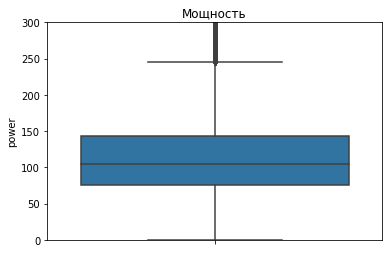

In [24]:
sns.boxplot(y='power', data=data).set(title='Мощность');
plt.ylim([0,300])

Основываясь на поиске в интернете, самая максимальная мощность автомобиля на сегодняшний день ~ 2000 л.с. Нижняя граница мощности современных автомобилей ~ 20 л.с. Поэтому установим релевантный диапазон мощности авто.

In [25]:
data = data.query('20 < power < 2000')
data.shape

(286869, 16)

In [26]:
#удалим неинформативные колонки
data = data.drop(['datecrawled','datecreated', 'number_of_pictures', 'postalcode',
       'lastseen'], axis=1)
data.shape

(286869, 11)

### Исследовательский анализ данных

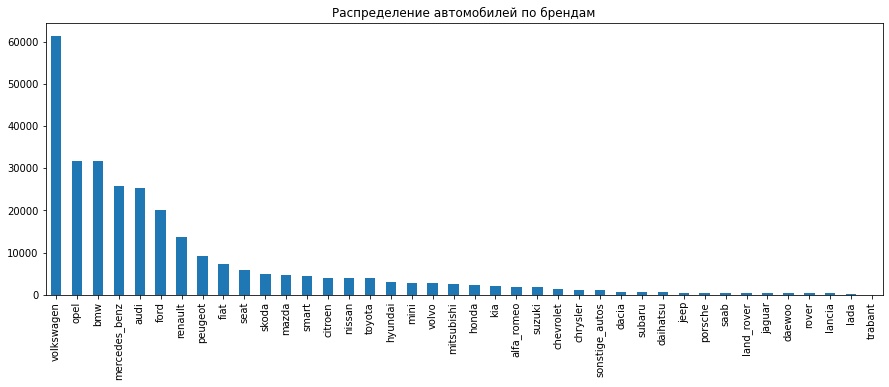

In [27]:
(
    data['brand'].value_counts()
    .plot(kind='bar', figsize=(15,5), title='Распределение автомобилей по брендам')
);

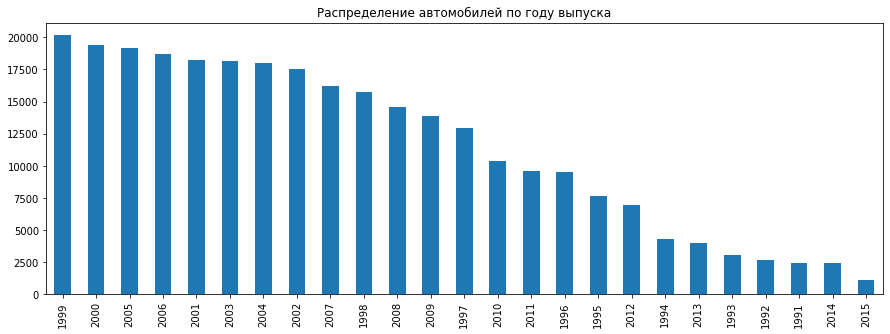

In [28]:
(
    data['registration_year'].value_counts()
    .plot(kind='bar', figsize=(15,5), title='Распределение автомобилей по году выпуска')
);

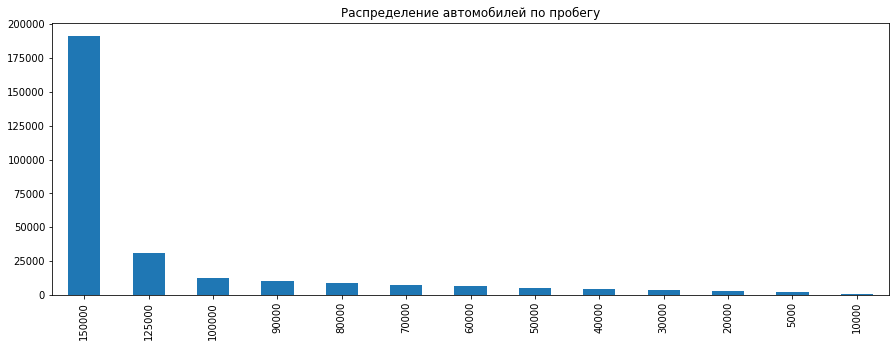

In [29]:
(
    data['kilometer'].value_counts()
    .plot(kind='bar', figsize=(15,5), title='Распределение автомобилей по пробегу')
);

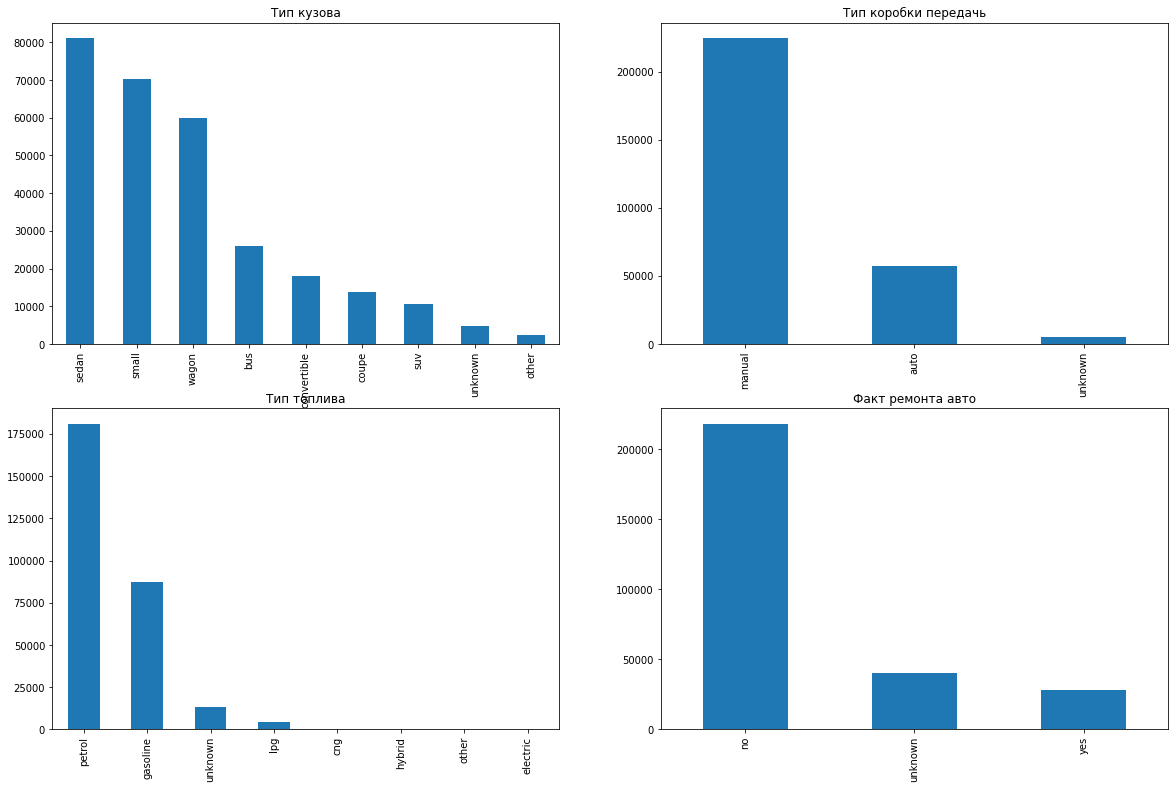

In [30]:
fig, axis = plt.subplots(2,2 , figsize=(20,13))

data['vehicle_type'].value_counts().plot(kind='bar', x='vehicle_type', ax=axis[0,0]).set(title='Тип кузова');
data['gearbox'].value_counts().plot(kind='bar', x='gearbox', ax=axis[0,1]).set(title='Тип коробки передачь');
data['fuel_type'].value_counts().plot(kind='bar', x='fuel_type', ax=axis[1,0]).set(title='Тип топлива');
data['repaired'].value_counts().plot(kind='bar', x='repaired', ax=axis[1,1]).set(title='Факт ремонта авто');

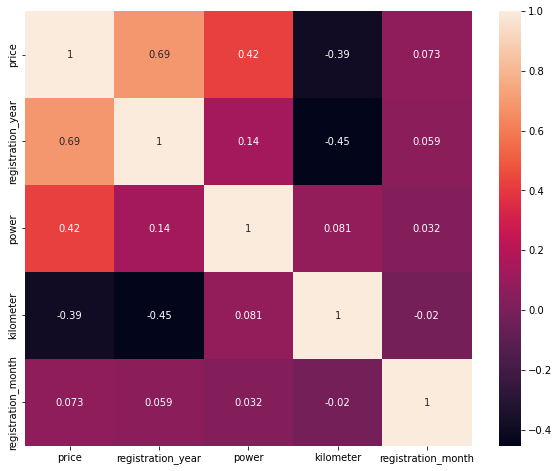

In [31]:
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True);

**ВЫВОД**  

- данные успешно загружены
- названия столбцов приведены к стандартному виду
- типы данных в норме
- выявлены пропуски в 5 столбцах, пропуски заменены на "unknown"
- удалены неинформативные столбцы
- выявлены и удалены явные дубликаты
- неявных дубликатов не выявлено  

- выявлены и устранены аномалии в столбцах 'registration_year' и 'power'
- выбран актуальный перод выпуска автомобилей: *с 1990 по 2023 г.г.*
- выбран барьер для мощности автомобиля: не более 200 л.с.  

- основные представленые бренды:
    - volkswagen
    - opel
    - bmw
    - mercedes_benz
    - ford
    - audi
- основные типы кузова:
    - small
    - sedan
    - wagon
- в основном представлены автомобили, выпущенные в период *1998-2006 г.г.*
- автомобили, выпущенные за последние 3-5 лет, в меньшинтсве
- в основном представлены автомобили c механической коробкой передач
- в основном представлены автомобили, функционирующие на бензине
- у большинства автомобилей пробег составляет *150 тыс. км*
- большинство автомобилей не ремонтировалось  

- выявлена умеренная корреляциям между годом регистрации и ценой
- выявлена средняя корреляциям между мощностью и ценой

In [32]:
data['registration_month'].unique()

array([ 5,  8,  6,  7, 10,  0, 12, 11,  2,  3,  1,  4,  9])

In [33]:
data.query('registration_month == 0')

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
9,999,small,1998,manual,101,golf,150000,0,unknown,volkswagen,unknown
36,1600,other,1991,manual,75,kadett,70000,0,unknown,opel,unknown
80,250,wagon,2000,manual,155,156,150000,0,petrol,alfa_romeo,yes
92,250,unknown,2000,unknown,60,ka,150000,0,unknown,ford,unknown
104,300,convertible,1992,manual,105,escort,150000,0,unknown,ford,yes
...,...,...,...,...,...,...,...,...,...,...,...
354260,399,other,1994,unknown,1103,3er,150000,0,unknown,bmw,unknown
354297,400,wagon,1996,manual,150,a4,150000,0,petrol,audi,unknown
354326,1300,small,1999,manual,75,2_reihe,125000,0,unknown,peugeot,unknown
354329,350,small,1996,unknown,65,punto,150000,0,unknown,fiat,unknown


***Вывод:*** столбец "registration_month" содержит аномальное значение - 0, что просто говорит о том, что месяц не был указан.

In [34]:
data['price'].describe()

count    286869.000000
mean       4811.816062
std        4626.523717
min           0.000000
25%        1299.000000
50%        3100.000000
75%        6990.000000
max       20000.000000
Name: price, dtype: float64

In [35]:
len(data.query('price == 0'))

5569

***Вывод:*** обнаружена аномалия в столбце 'price' - нулевое значение цены. Строк с такими значениями немного,удалим их датасета.

In [36]:
data = data.query('price > 0')
len(data)

281300

## Обучение моделей

Итак, для обучения и дальнейшего сравнения были выбраны следующие модели:

- *Ridge*
- *Random Forest*
- *LightGBM*  

Для каждой модели будет создан пайплайн вместе с кросс-валидаций, что позволит кодировать и масштабировать отдельно обучающию и тестовую выборки внутри кросс-валидации.

In [37]:
features = data.drop(['price'], axis=1)
target = data['price']

In [38]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE)

### *Ridge*

In [39]:
features_train_ridge = features_train.copy()
features_test_ridge = features_test.copy()

In [40]:
#категориальные признаки для OHE
ohe_features = features_train.select_dtypes(include='object').columns.to_list()
ohe_features

['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

In [41]:
# численные признаки
num_features = features_train.select_dtypes(exclude='object').columns.to_list()
num_features

['registration_year', 'power', 'kilometer', 'registration_month']

In [42]:
# признак repaired уже бинарный, его не будем кодировать/масштабировать
# добавляем remainder='passthrough, чтобы он не пропал 
col_transformer_ridge = make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'),
        ohe_features
    ),
    (
        StandardScaler(), 
        num_features
    ),
    remainder='passthrough',
    verbose_feature_names_out=False
)

# всё готово в пару строк кода
features_train_ridge = pd.DataFrame.sparse.from_spmatrix(
    col_transformer_ridge.fit_transform(features_train_ridge),
    columns=col_transformer_ridge.get_feature_names_out()
)

# смотрим на результат
features_train_ridge.head()

,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_unknown,vehicle_type_wagon,gearbox_manual,gearbox_unknown,...,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_unknown,repaired_yes,registration_year,power,kilometer,registration_month
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,-0.026960,-0.756291,0.590359,-1.409972
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.942331,-0.549535,0.590359,-0.568960
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.383966,0.038926,0.590359,-0.849298
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.554615,0.134352,0.590359,-0.288623
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,-0.608534,-1.074378,0.590359,-1.690309


In [43]:
features_train_ridge = features_train.copy()

In [44]:
model_ridge = Ridge(random_state=RANDOM_STATE)

In [45]:
pipeline_ridge = make_pipeline(col_transformer_ridge, model_ridge)

param_grid_ridge = {
    'ridge__alpha': np.arange(0, 0.21, 0.01),
}

gs_ridge_pl = GridSearchCV(
    pipeline_ridge, 
    param_grid=param_grid_ridge, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1
)

In [46]:
gs_ridge_pl.fit(features_train_ridge, target_train)
gs_ridge_best_params = gs_ridge_pl.best_params_
print(f'Лучшие гиперпараметры: {gs_ridge_best_params}')

Лучшие гиперпараметры: {'ridge__alpha': 0.14}


In [47]:
start_time = time.time()
gs_ridge_pl.best_estimator_.fit(features_train_ridge, target_train)
end_time = time.time()
train_time = end_time - start_time
print(f'Время обучения: {train_time:.2f} секунд')
gs_ridge_best_score = gs_ridge_pl.best_score_ * -1
print(f'RMSE на кросс-валидации: {gs_ridge_best_score}')

Время обучения: 1.33 секунд
RMSE на кросс-валидации: 2276.852438256857


In [48]:
start_time = time.time()
gs_ridge_pl.best_estimator_.predict(features_train_ridge)
end_time = time.time()
param_time = end_time - start_time
print(f'Время предсказания: {param_time:.2f} секунд')

Время предсказания: 0.54 секунд


### *Random Forest*

In [51]:
features_train_rf = features_train.copy()
features_test_rf = features_test.copy()

In [52]:
# преобразуем категориальные признаки в численные техникой прямого кодирования
encoder = OneHotEncoder(handle_unknown='error', drop='first', sparse=False)

encoder.fit(features_train[ohe_features])

features_train[
    encoder.get_feature_names_out()
] = encoder.transform(features_train[ohe_features])

# удаляем незакодированные категориальные признаки (изначальные колонки)
features_train = features_train.drop(ohe_features, axis=1)
features_train.head()

,registration_year,power,kilometer,registration_month,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_unknown,repaired_yes
272964,2003,75,150000,1,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
338713,2008,88,150000,4,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
276472,1996,125,150000,3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
227136,2006,131,150000,5,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
306219,2000,55,150000,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [53]:
# энкодером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, кодируем тестовую выборку
features_test[
    encoder.get_feature_names_out()
] = encoder.transform(features_test[ohe_features])

features_test = features_test.drop(ohe_features, axis=1)
features_test

,registration_year,power,kilometer,registration_month,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_unknown,repaired_yes
281320,2002,131,150000,7,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
86214,2005,155,150000,9,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
311493,1999,101,150000,9,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
302352,2010,204,125000,7,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62785,2001,60,80000,1,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188480,1994,101,150000,6,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
126659,2002,75,150000,1,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
336485,1999,115,150000,3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51852,1998,133,150000,8,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
#масштабируем численные признаки
scaler = StandardScaler()

features_train[num_features] = scaler.fit_transform(features_train[num_features])
features_test[num_features]  = scaler.transform(features_test[num_features])

features_train.head()

,registration_year,power,kilometer,registration_month,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_unknown,repaired_yes
272964,-0.026960,-0.756291,0.590359,-1.409972,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
338713,0.942331,-0.549535,0.590359,-0.568960,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
276472,-1.383966,0.038926,0.590359,-0.849298,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
227136,0.554615,0.134352,0.590359,-0.288623,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
306219,-0.608534,-1.074378,0.590359,-1.690309,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [55]:
#поиск оптимальных гиперпараметров
# start_time = time.time()
for estim in range (60, 63):
    for depth in range(10, 12):
        model = RandomForestRegressor(n_estimators=estim, max_depth=depth, random_state=RANDOM_STATE)
        model.fit(features_train, target_train)
        mse = cross_val_score(model, features_train, target_train, cv=5, scoring='neg_mean_squared_error')
        
        print('n_estimators =', estim, 'max_depth =', depth, 'RMSE =', (-mse.mean()) ** 0.5)
# end_time = time.time()
# param_time = end_time - start_time

n_estimators = 60 max_depth = 10 RMSE = 1788.3759311598872
n_estimators = 60 max_depth = 11 RMSE = 1735.5143755697482
n_estimators = 61 max_depth = 10 RMSE = 1788.144584705421
n_estimators = 61 max_depth = 11 RMSE = 1735.3106030453446
n_estimators = 62 max_depth = 10 RMSE = 1788.0677517125484
n_estimators = 62 max_depth = 11 RMSE = 1735.2582507622558


In [56]:
start_time = time.time()
model = RandomForestRegressor(n_estimators=62, max_depth=11, random_state=RANDOM_STATE)
model.fit(features_train, target_train)
end_time = time.time()
train_time = end_time - start_time
#суммарное время обучения и подбора гиперпараметров
#total_time = param_time + train_time
print(f'Время обучения:  {train_time:.2f} секунд')
mse = cross_val_score(model, features_train, target_train, cv=5, scoring='neg_mean_squared_error')
print(f'RMSE на кросс-валидации: {round((-mse.mean()) ** 0.5, 2)}')

Время обучения:  216.14 секунд
RMSE на кросс-валидации: 1735.26


In [57]:
start_time = time.time()
predictions = model.predict(features_train)
end_time = time.time()
pred_time = end_time - start_time
print(f'Время предсказания:  {pred_time:.2f} секунд')

Время предсказания:  2.47 секунд


### LightGBM

In [58]:
#поиск оптимальных гиперпараметров
# start_time = time.time()

for depth in range(15, 35, 5):
        model = LGBMRegressor(max_depth=depth, random_state=RANDOM_STATE)
        model.fit(features_train, target_train)
        mse = cross_val_score(model, features_train, target_train, cv=5, scoring='neg_mean_squared_error')
        
        print('max_depth =', depth, 'RMSE =', (-mse.mean()) ** 0.5)

# end_time = time.time()
# param_time = end_time - start_time

max_depth = 15 RMSE = 1579.501406949028
max_depth = 20 RMSE = 1578.1393575307447
max_depth = 25 RMSE = 1578.5105846192616
max_depth = 30 RMSE = 1578.3387051604118


In [60]:
start_time = time.time()
model = LGBMRegressor(max_depth=20, random_state=RANDOM_STATE)
model.fit(features_train, target_train)
end_time = time.time()
train_time = end_time - start_time
#суммарное время обучения и подбора гиперпараметров
#total_time = param_time + train_time
print(f'Время обучения: {train_time:.2f} секунд')
mse = cross_val_score(model, features_train, target_train, cv=5, scoring='neg_mean_squared_error')
print(f'RMSE на кросс-валидации: {round((-mse.mean()) ** 0.5, 2)}')

Время обучения: 6.02 секунд
RMSE на кросс-валидации: 1578.14


In [61]:
start_time = time.time()
predictions = model.predict(features_train)
end_time = time.time()
pred_time = end_time - start_time
print(f'Время предсказания:  {pred_time:.2f} секунд')

Время предсказания:  2.08 секунд


**Вывод**

Лушая Ridge модель: **Ridge('ridge__alpha': 0.1, random_state=RANDOM_STATE)**
- Время обучения: 1.33 секунд
- RMSE на кросс-валидации: 2276.85
- Время предсказания: 0.54 секунд

Лушая RandomForestRegressor модель: **RandomForestRegressor(n_estimators=62, max_depth=11, random_state=RANDOM_STATE)**
- Время обучения: 216.14 секунд
- RMSE на кросс-валидации: 1735.26
- Время предсказания: 2.47 секунд

Лушая LGBMRegressor модель: **LGBMRegressor(max_depth=30, random_state=RANDOM_STATE)**
- Время обучения: 6.02 секунд
- RMSE на кросс-валидации: 1578.14
- Время предсказания: 2.08 секунд

***Для тестирования выбираем модель LGBMRegressor т.к. имеет наилучшее качество и наименьшее время исполнения алгоритма.***

## Анализ моделей

Протестируем выбранную модель/

In [62]:
start_time = time.time()
predictions = model.predict(features_test)
end_time = time.time()
test_time = end_time - start_time
print(f'Время предсказания:  {test_time:.2f} секунд')
mse = cross_val_score(model, features_test, target_test, cv=5, scoring='neg_mean_squared_error')
print(f'RMSE: {round((-mse.mean()) ** 0.5, 2)}')

Время предсказания:  0.90 секунд
RMSE: 1586.25


**Вывод**: качество предсказания на тестовой выборке не сильно хуже, чем на обучающей, и удовлетворяет условию задания.